In [ ]:
# https://github.com/ogrisel/notebooks/blob/master/sklearn_demos/Face%20recognition.ipynb

## Labeled Faces in the Wild (LFW)

In [1]:
from __future__ import print_function
from time import time
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import logging
from sklearn.datasets import fetch_lfw_people

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data
n_samples, n_features = X.shape

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
print("height: %d pixels" % h)
print("width: %d pixels" % w)

height: 50 pixels
width: 37 pixels


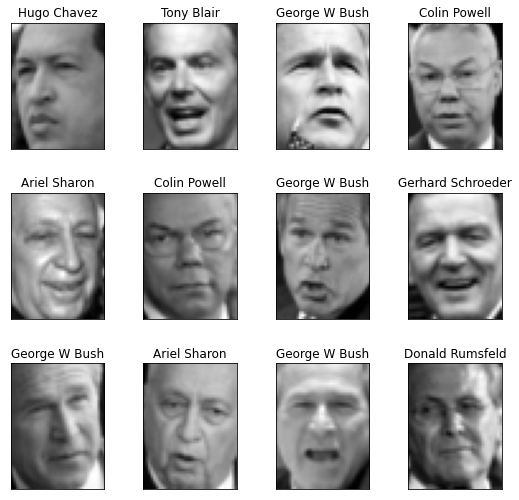

In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

        
plot_gallery(X, target_names[y], h, w)

Split dataset into a training and testing set

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

### Compute a PCA (eigenfaces) on the face dataset

Unsupervised feature extraction / dimensionality reduction

Extracting the top 150 eigenfaces from 966 faces
done in 0.100s


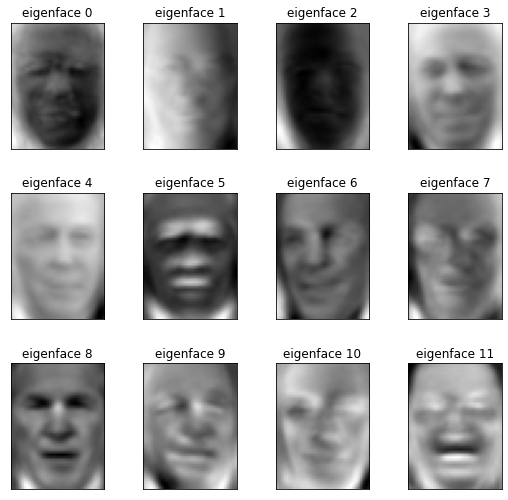

In [6]:
from sklearn.decomposition import PCA

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

# When True (False by default) the components_ vectors are multiplied by the square root of n_samples and then 
# divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.
# Whitening will remove some information from the transformed signal (the relative variance scales of the components) 
# but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some 
# hard-wired assumptions.

print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [7]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s


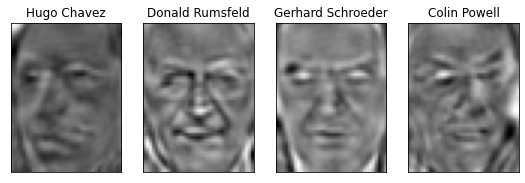

In [8]:
X_train_reconstructed = np.dot(X_train_pca, pca.components_)
plot_gallery(X_train_reconstructed, target_names[y_train], h, w, n_row=1)

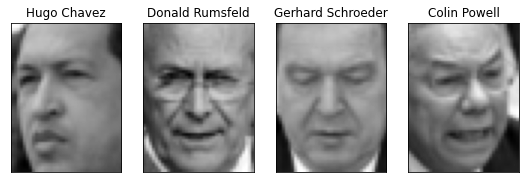

In [9]:
plot_gallery(X_train, target_names[y_train], h, w, n_row=1)

### Training on classification model on the new representation

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100],
              'gamma': [0.0001, 0.001, 0.01, 0.1]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=2)
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 6.184s
Best estimator found by grid search:
SVC(C=10, class_weight='balanced', gamma=0.001)


### Qualitative evaluation of the model quality on the test set

Predicting people's names on the test set
done in 0.036s


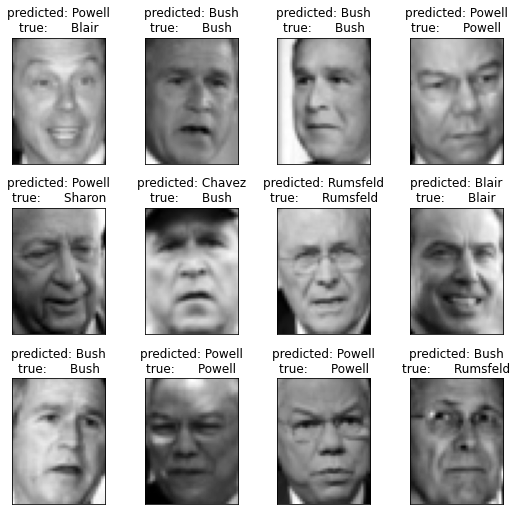

In [11]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

### Quantitative evaluation of the model quality on the test set

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.78      0.70        18
     Colin Powell       0.80      0.82      0.81        49
  Donald Rumsfeld       0.77      0.88      0.82        34
    George W Bush       0.91      0.91      0.91       139
Gerhard Schroeder       0.84      0.84      0.84        25
      Hugo Chavez       0.94      0.77      0.85        22
       Tony Blair       0.86      0.71      0.78        35

         accuracy                           0.85       322
        macro avg       0.82      0.82      0.82       322
     weighted avg       0.85      0.85      0.85       322



In [13]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[ 14   2   0   2   0   0   0]
 [  3  40   2   4   0   0   0]
 [  2   0  30   2   0   0   0]
 [  3   3   5 126   1   1   0]
 [  0   0   0   1  21   0   3]
 [  0   1   0   2   1  17   1]
 [  0   4   2   2   2   0  25]]
